In [1]:
import matplotlib.pyplot as plt 
import numpy as np 

In [ ]:
def legendre_symbol(a, p):
  return pow(a, (p - 1) // 2, p)

def tonelli(n, p): 
  q = p - 1
  s = 0 
  while q % 2 == 0: 
    q //= 2 
    s += 1 
  if s == 1: 
    return pow(n, (p+1) // 4, p)
  for z in range(2, p): 
    if p-1 == legendre_symbol(z, p): 
      break 
  c = pow(z, q, p) 
  r = pow(n, (q+1) // 2, p) 
  t = pow(n, q, p)
  m = s 
  t2 = 0 

  while (t-1) % p != 0: 
    t2 = (t*t) % p 
    for i in range(1, m): 
      if (t2 - 1) % p == 0: 
        break 
      t2 = (t2 * t2) % p 
    b = pow(c, 1 << (m - i - 1), p)
    r = (r * b) % p 
    c = (b * b) % p 
    t = (t * c) % p 
    m = i 
  return r 

In [179]:
def quadratic_residues(p): 
  y = list() 
  for i in range(p): 
    y.append(i**2 % p)
  return set(y)

In [217]:
def double(x, y, a, p):
  lambd = (((3 * x**2) % p ) *  pow(2 * y, -1, p)) % p
  newx = (lambd**2 - 2 * x) % p
  newy = (-lambd * newx + lambd * x - y) % p
  return (newx, newy)

def add_points(xq, yq, xp, yp, p, a=0):
  if xq == yq == None:
    return xp, yp
  if xp == yp == None:
    return xq, yq

  assert (xq**3 + 3) % p == (yq ** 2) % p, "q not on curve"
  assert (xp**3 + 3) % p == (yp ** 2) % p, "p not on curve"

  if xq == xp and yq == yp:
    return double(xq, yq, a, p)
  elif xq == xp:
    return None, None

  lambd = ((yq - yp) * pow((xq - xp), -1, p) ) % p
  xr = (lambd**2 - xp - xq) % p
  yr = (lambd*(xp - xr) - yp) % p
  return xr, yr


def count_points_on_curve(a, b, p):
    """Count the number of points on the elliptic curve y^2 = x^3 + ax + b over F_p."""
    if p < 2 or pow(4 * a**3 + 27 * b**2, 1, p) == 0:  # Check if curve is singular
        raise ValueError("Invalid curve: singular or p too small.")
    
    points = 1  # Include the point at infinity
    for x in range(p):
        # Compute y^2 = x^3 + ax + b mod p
        y_squared = (x**3 + a * x + b) % p
        if legendre_symbol(y_squared, p) == 1:
            # If y^2 is a quadratic residue, there are two points (x, y), (x, -y) unless y = 0
            if y_squared == 0:
                points += 1
            else:
                points += 2
    return points

In [222]:
count_points_on_curve(a, b, 43)

49

In [210]:
# y^2 = x^3 + a*x + b mod p 

a = 0
b = 3
p = 11

x = np.arange(p)

In [211]:
assert 0 > (-16 * (4 * a**3 + 27 * b**2)), "not negative"

coords = list()
qr = quadratic_residues(p)
print(qr)
for i in range(p): 
  out = (i**3 + a*i + b) % p
  if out in qr: 
    if out != 0: 
      sq_root = tonelli(out, p)
    else: 
      sq_root = 0 
    coords.append([i, sq_root])
    coords.append([i, p - sq_root])

{0, 1, 3, 4, 5, 9}


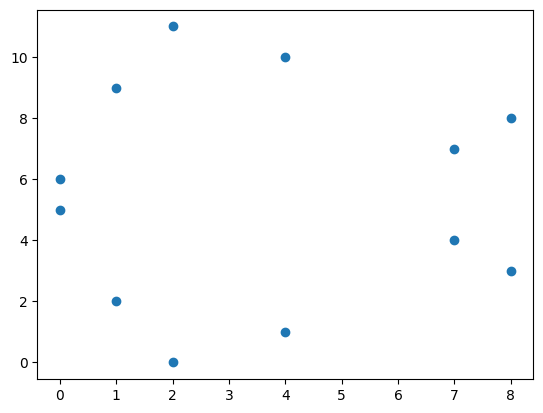

In [212]:
plt.scatter(np.asarray(coords)[:, 0], np.asarray(coords)[:, 1])

In [207]:
len(coords), coords[11]

(42, [14, 41])

In [215]:
next_x, next_y = 4, 10
print(1, next_x, next_y)
points = [(next_x, next_y)]

for i in range(1, p+2): 
  next_x, next_y = add_points(next_x, next_y, 4, 10, p)
  print(i, next_x, next_y) 
  points.append((next_x, next_y))

1 4 10
1 7 7
2 1 9
3 0 6
4 8 8
5 2 0
6 8 3
7 0 5
8 1 2
9 7 4
10 4 1
11 None None
12 4 10


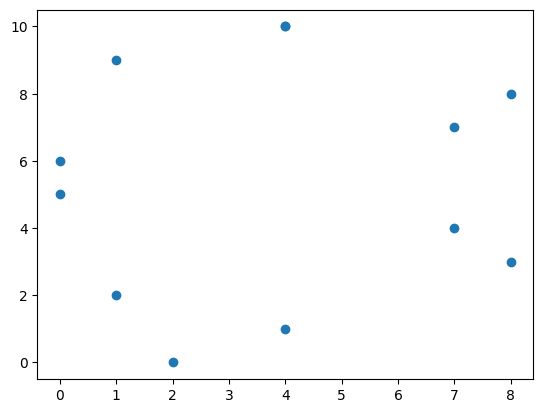

In [216]:
plt.scatter(np.asarray(points)[:, 0], np.asarray(points)[:, 1])